###### Artificial Intelligence & Machine Learning (623.504, 20W) - Bhuwan Sharma (bhuwansh@edu.aau.at)

# Skin Lesions Detection using Convolutional Neural Networks

## Motivation
The objective of this project is to classify skin lesions using Machine Learning techniques. Skin cancer is one of the most deadly diseases in humans and is often ignored by people at an early stage. Considering "Errare humanum est" and manual examination to diagnose skin cancer can be time-consuming and tedious, we need a computer-aided system that can help dermatologists to accurately diagnose skin cancer in its early stages. Therefore, the automated classification of skin lesions will save effort, time, and human life.

In [1]:
%matplotlib inline
# %load_ext tensorboard # Load the TensorBoard notebook extension
import math # to have LaTeX
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from os.path import basename, dirname
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from scipy import stats

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# TensorFlow: an open-source library used for the implementation of neural network architectures 
# that run on both CPUs and GPUs.
import tensorflow as tf
import datetime
# Keras: a high level API built on TensorFlow. It is more user-friendly and easy to use as
# compared to TF. 
import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

In [2]:
dataset_dir = os.path.join('/Users/bhuwan/Downloads/AI&ML/dataset')

### Loading the images
The dataset used in this project is [HAM10000](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T) which is split into two folders "HAM10000_images_part_1" and "HAM10000_images_part_2".

In [3]:
# Merge images from both folders into one dictionary.
imageId_path_dict = {
                        # Extract the file name (without the extension) and
                        # map it to the file (path)
                        os.path.splitext(os.path.basename(x))[0]: x
                         for x in 
                             # Return all the .jpg files in base_skin_dir
                             glob(os.path.join(dataset_dir, '*', '*.jpg'))
                    }

# Each image is categorized in one of the following labels.
# This dictionary is useful for displaying more human-friendly labels for
# diagnostic categories in the realm of pigmented lesions.
lesionType_label_dict = {
    'akiec': 'Actinic keratoses (akiec)', # Actinic keratoses and intraepithelial carcinoma / Bowen's disease
    'bcc': 'Basal cell carcinoma (bcc)',
    'bkl': 'Benign keratosis-like lesions (bkl)', # (solar lentigines / seborrheic keratoses and lichen-planus like keratoses)
    'df': 'Dermatofibroma (df)',
    'mel': 'Melanoma (mel)',
    'nv': 'Melanocytic nevi (nv)',
    'vasc': 'Vascular lesions (vasc)' # (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage)
}

### Creating the DataFrame with lesion details

- lesion_id: there can be lesions with multiple images
- image_id: corresponding image file name
- dx: lesion type
- dx_type: more than 50% of lesions are confirmed through histopathology (histo),
the ground truth for the rest of the cases is either follow-up examination (follow_up),
expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal).
- age: age of the patient
- sex: sex of the patient
- localization: describes where the skin lesion is located

In [4]:
# Converting csv into pandas DataFrame
metadata_df = pd.read_csv(os.path.join(dataset_dir, 'HAM10000_metadata.csv'))

# Example of metadata file content.
metadata_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
# Create some new columns (relative path to image, human-readable skin disease name)

metadata_df['disease_name'] = metadata_df['dx'].map(lesionType_label_dict.get) 

metadata_df['path'] = metadata_df['image_id'].map(imageId_path_dict.get)

metadata_df['dataset'] = metadata_df['image_id'].map(lambda x: 
                                                    basename(dataset_dir) + "/" +
                                                    basename(
                                                        dirname(imageId_path_dict.get(x))
                                                    ))

# Mapping each lesion (string) type to an integer
# Needed for CNN later
metadata_df['cell_type_idx'] = pd.Categorical(metadata_df['dx']).codes

metadata_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,disease_name,path,dataset,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions (bkl),/Users/bhuwan/Downloads/AI&ML/dataset/HAM10000...,dataset/HAM10000_images_part_1,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions (bkl),/Users/bhuwan/Downloads/AI&ML/dataset/HAM10000...,dataset/HAM10000_images_part_1,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions (bkl),/Users/bhuwan/Downloads/AI&ML/dataset/HAM10000...,dataset/HAM10000_images_part_1,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions (bkl),/Users/bhuwan/Downloads/AI&ML/dataset/HAM10000...,dataset/HAM10000_images_part_1,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions (bkl),/Users/bhuwan/Downloads/AI&ML/dataset/HAM10000...,dataset/HAM10000_images_part_2,2


### Let's see how the data is distributed based on each lesion type

<AxesSubplot:>

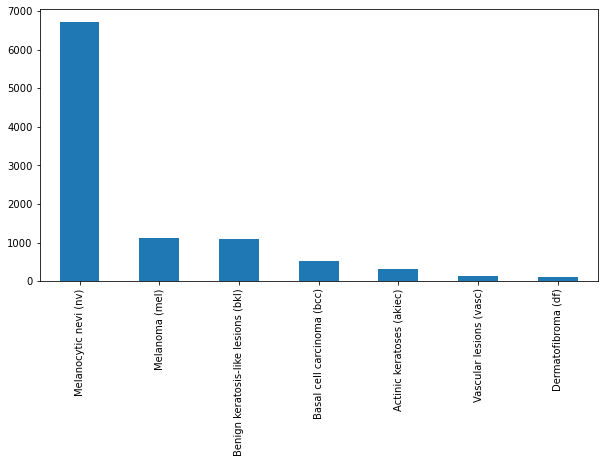

In [6]:
# Disease type
fig = plt.figure(figsize=(10,5))
ax1 = fig.subplots()
metadata_df['disease_name'].value_counts().plot(kind='bar', ax=ax1)

In [7]:
metadata_df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

#### Diagram analysis
There are too many melanocytic nevi - We need to balance our dataset. There are many more images for the lesion type “Melanocytic Nevi” or “nv” (> 6500) compared to other types like “dermatofibroma” or “df” (< 500).

From now on, we will refer to the "lesion type" (`dx` column) as the "class" of the specific lesion.

Training our model without minimizing this imbalance would introduce bias towards the over-represented classes and won’t have the chance to learn the distributions of the under-represented ones, making our work futile.
This is a perfect example of why it is so important to analyze the data beforehand.

### Some additional data properties

/Users/bhuwan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

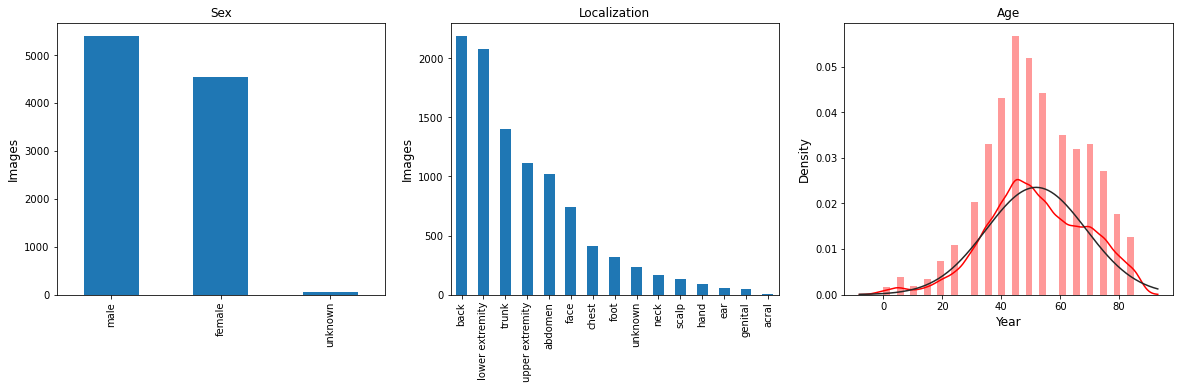

In [8]:
fig = plt.figure(figsize=(20, 5))

# Patient Sex
ax2 = fig.add_subplot(1, 3, 1)
metadata_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Images', size=12)
ax2.set_title('Sex');

# Disease Location
ax3 = fig.add_subplot(1, 3, 2)
metadata_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Images', size=12)
ax3.set_title('Localization')

# Patient Age
ax4 = fig.add_subplot(1, 3, 3)
ax4.set_title('Age')
sample_age = metadata_df[pd.notnull(metadata_df['age'])] # Extract all rows having age
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_xlabel('Year', size=12)
ax4.set_ylabel('Density', size=12)

In the third diagram, we can see a "Bell Curve" in the graph, this means there is a Normal Distribution: the data is "normally distributed".

The peak age for skin cancer is found at 45 years, while they are more common between the age of 30 to 70.

In [9]:
# TODO: Plot images' dimensions

# AlexNet wants 227 x 227 sized images.
image_size = (227, 227)

# Load in all of the images into memory - this will take a while.  
# We also do a resize step because the original dimensions of 600x450
# is too much for our machine.

metadata_df['image'] = metadata_df['path'].map(lambda x: np.asarray(Image.open(x).resize(image_size)))

# In machine learning, Python uses image data in the form of a 
# NumPy array, i.e., [Height, Width, Channel] format to enhance the
# performance of the predictive model.

# np.asarray() - NumPy uses the asarray() class to convert PIL images 
# into NumPy arrays.
# Image.open(x).resize(image_size) - The Image class is the heart of
# Pillow (PIL) Library which allows image manipulation, resize) in 
# our case.

In [10]:
print(metadata_df['image'].head())
print(metadata_df['image'][0].shape)

0    [[[187, 150, 192], [190, 154, 195], [192, 156,...
1    [[[24, 13, 22], [25, 13, 23], [24, 14, 23], [2...
2    [[[186, 127, 135], [188, 129, 137], [191, 135,...
3    [[[23, 11, 15], [24, 11, 18], [24, 10, 19], [2...
4    [[[124, 83, 105], [132, 89, 112], [138, 93, 11...
Name: image, dtype: object
(227, 227, 3)


### Let's now see a sample of the dataset

For each lesion type, we will display 6 random samples => 7x6 matrix.

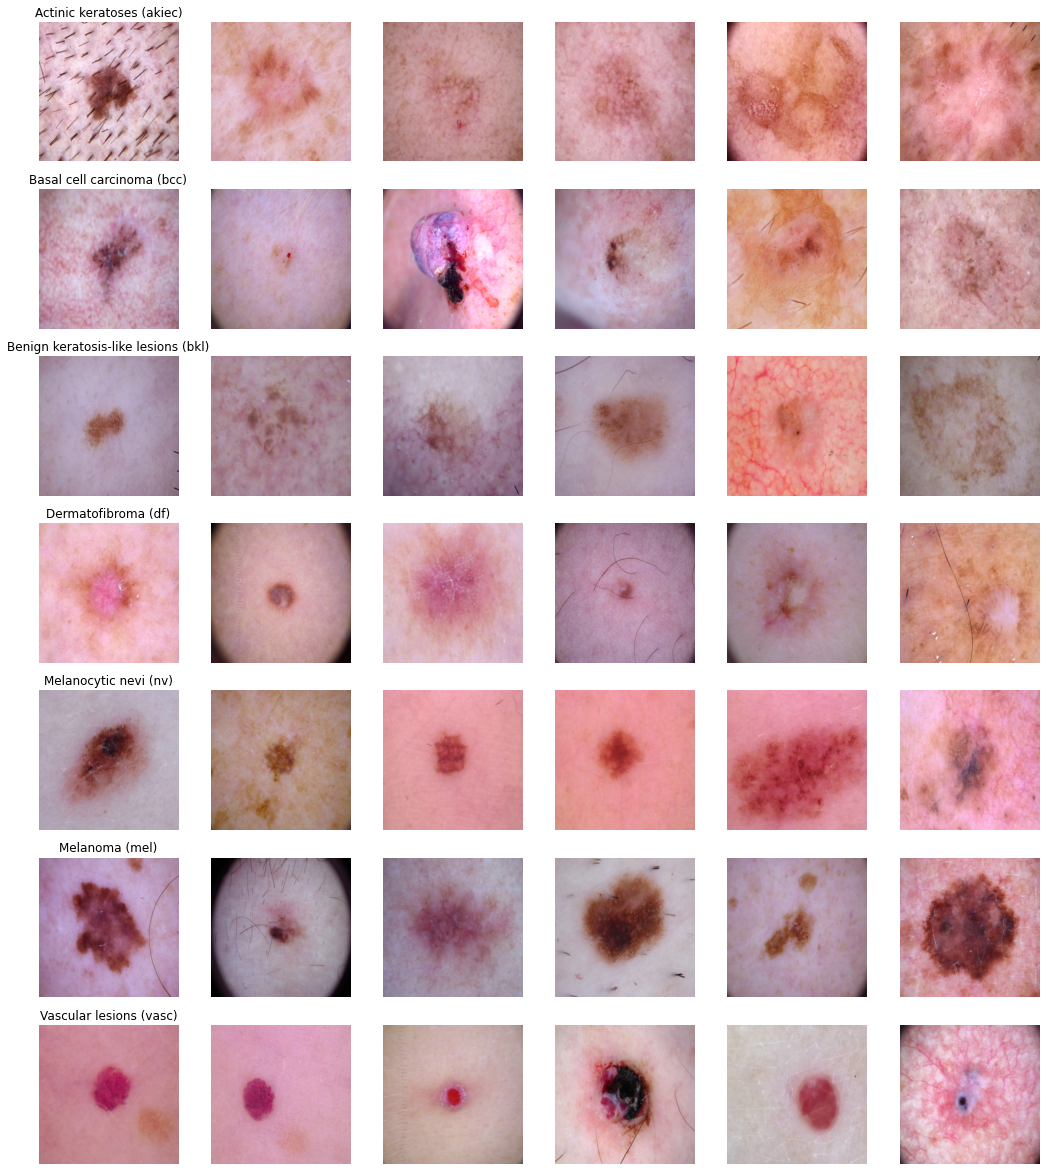

In [11]:
# rows
count_types_of_lesions = len(lesionType_label_dict)
# columns
n_samples = 6

# figsize multiplier: a factor that amplifies or increase the base value of
# figure width and height.
figsize_m = (n_samples / 2)

# Constructing ROW x COLUMN matrix (m_axs); ROWS: 7, COLUMNS: 6
# lesion_sample_axs: array of Axes (count_types_of_lesions)
fig, lesion_sample_axs = plt.subplots(nrows=count_types_of_lesions,
                                      ncols=n_samples,
                                      figsize = (figsize_m * n_samples,
                                                 figsize_m * count_types_of_lesions))

# We will now populate the plots matrix with 2 for loops

# zip(a, b) returns a zip object which then is unpacked with a for loop
# i_axs: i-th row of the subplots (lesion_sample_axs) matrix[i_axs, j_axs]
for i_axs, (disease_name, disease_rows) in zip(lesion_sample_axs,
                                            metadata_df.sort_values(['disease_name']).groupby('disease_name')):
    # Setting title of 1st column plots
    i_axs[0].set_title(disease_name)

    for j_ax, (_, j_row) in zip(i_axs,
                                # disease_rows.sample(n, random_state=r)
                                # n: number of items from axis to return
                                # r: seed for a pseudo random number generator
                                disease_rows.sample(n_samples, random_state=2021).iterrows()):
        j_ax.imshow(j_row['image'])
        j_ax.axis('off')
        
# 'x'.join(map(str,image_size)): 227x227 will be appended to the filename
fig.savefig('skin_lesions_samples-' + 'x'.join(map(str, image_size)) + '.png', dpi=300)

This also gives us a first impression of the difficulty of our task. For us it is easy to differentiate between a cat and a dog. On the other hand, it is not trivial for a non-medical person to distinguish the two classes “melanoma” and “vascular lesions” due to the lack of experience in this field.

## Balancing the imbalances
There are several techniques to overcome the imbalanced training data ([source](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)). Here are some of them:
1. **Collecting more data**. Even though it might sound silly, but collecting more data could help us having a more balanced dataset.
2. **Resampling the dataset**. We could simply add more copies of the under-represented classes (over-sampling), or delete some instances of the over-represented classes (under-sampling);
3. **SMOTE** (Synthetic Minority Oversampling TEchnique). The idea behind SMOTE is to create synthentic/artificial images based on the features of the images in the under-represented class.
4. **[Median Frequency Balancing](https://arxiv.org/pdf/1411.4734v4.pdf)**. In this tecnique we weight each pixel by $\alpha_{c}$ = median freq/freq(_c_) where freq(_c_) is the number of pixels of class _c_ divided by the total number of pixels in images where _c_ is present, and median frequency is the median of these frequencies. In other words we could say:

     a) "number of pixels of class _c_": represents the total number of pixels of class _c_ across all images of the dataset.
     
     b) "the total number of pixels in images where _c_ is present": represents the total number of pixels across all images (where there is at least one pixel of class _c_) of the dataset.
     
     c) "median frequency is the median of these frequencies": sort the frequencies calculated above and pick the median.
     
In our case, we will use the Median Frequency Balancing technique to balance our dataset.

In [19]:
# Counting number of images per lesion type
lesion_type_count_series = metadata_df['cell_type_idx'].value_counts()

def mfb_weights(lesion_type_count_series):
    # Median: 514.0
    median_freq = np.median(lesion_type_count_series.values)
    # x: number of images for a lesion type
    class_weights = lesion_type_count_series.apply(lambda x: median_freq / x)
    
    return class_weights

class_weight = mfb_weights(lesion_type_count_series)

print(class_weight)

5    0.076659
4    0.461815
2    0.467698
1    1.000000
0    1.571865
6    3.619718
3    4.469565
Name: cell_type_idx, dtype: float64


We now have a weight for each class of skin lesion and we can use it to compensate the imbalance and train our model later.

## Data (Image) Augmentation
Data augmentation is a series of techniques to increase the training samples in our dataset and increase the variance our network is exposed to during training.
Methods such as translation, rotation, viewpoint, or illumination changes (or a combination of the above) can help our model become robust to small alterations in the images.

#### Data Normalization
Normalization is a technique often applied as part of data preparation for machine learning.
The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values.
Not every dataset requires normalization.
It is required only when features have different ranges. **BatchNormalization** is an example of a data normalization technique (later used in our CNN model).

## Train, Validate and Test
It is common practice to split the dataset into three parts, training, validation, and test dataset when training a neural network.
The purpose of splitting data into three different collections of images is to avoid overfitting and improve the generalization of the model:

- **training dataset**: will be used to train the model. We will use the metadata file provided in HAM10000 dataset as the source of truth and educate our model by matching each image to the correct skin lesion;
- **validation dataset**: useful to check how well we trained our model;
- **test dataset**: the moment of truth; useful to make an evaluation of the previously trained clas- sifier. This will also tell us if we are under or overfitting our model and make some adjustments if needed.

### Some precautions when splitting data
As a rule of thumb, we will try to stick to 60% - 20% - 20%:
- Training dataset: 60%
- Validation dataset: 20%
- Test dataset: 20%

#### Stratified sampling
We have to make reduce as much as possible the imbalances by distributing an equal percentage of every type of skin lesion. For instance, if we have 100 images of skin lesion type A, then we have to use 60 images of type A in the training phase, 20 for validation, and 20 for testing.

As a result, if the data set has a large amount of each class, **stratified sampling** is pretty much the same as random sampling. But if one class is under-represented in the dataset, then stratified sampling will return a different target class distribution in the train and test sets than what random sampling may do.

In [13]:
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

X = metadata_df
# y = metadata_df['dx'].tolist()
# y = metadata_df['dx']
y = metadata_df['cell_type_idx']

# Randomly split the images into training and test set such that the
# training set has 60% of the images of the dataset and 20% as test set.
# We want to preserve the dataset proportions for better prediction and 
# reproduceability of results: stratify=y.
# Since the dataset is unbalanced, we are using the 'stratify' parameter 
# in order to split the dataset in a way so that the test set will contain 
# the same proportion of samples as the dataset for each lesion type.
# For example, if variable y is a binary categorical variable with values 0 and 1 
# and there are 25% of zeros and 75% of ones, stratify=y will make sure that 
# your random split has 25% of 0's and 75% of 1's.

# X_train is now 60% of the entire dataset and the rest in X_remain
# X: represents the input (a set images)
# y: represents the output. For each image we know its lesion type (as integer)
X_train, X_remain, y_train, y_remain = train_test_split(X, y, train_size=train_ratio, random_state=0, stratify=y)

# The remaining 40% of the images need to be splitted 50% for the test and 50% for validation
new_test_ratio = np.around(test_ratio / (validation_ratio + test_ratio), 2)

# X_train (training dataset) is now 60% of the entire dataset
# X_val (validation dataset) is 20%
# X_test (testing dataset) is 20%
X_test, X_val, y_test, y_val = train_test_split(X_remain, y_remain, test_size=new_test_ratio, random_state=0, stratify=y_remain)

print("Train Data Size:", len(X_train))
print("Validation Data Size:", len(X_val))
print("Test Data Size:", len(X_test))

Train Data Size: 6009
Validation Data Size: 2003
Test Data Size: 2003


### Artificial Neural Network (ANN)
Human brains are made up of connected networks of neurons.
Artificial Neural Network, also known as Neural Network, reproduces these networks artificially so that computers behave like interconnected brain cells: learn and make decisions in a human-like manner.

An ANN consists of the following components:
- Neurons: each artificial neuron has inputs and produces a single output which can be sent to multiple other neurons
- Connection and weights: connections are used to transmit data across the neural network and weights are variables in the neural network that are updated continuously to improve network’s accuracy. A weight is applied to input of each of the neuron to compute an output.
- Propagation function: a function that is used to transport values through the neurons of a neural net's layers. Usually, the input values are added up and passed to an activation function, which generates an output.
- Learning rate: it is a hyperparameter that controls how quickly the model is adapted to the problem. Smaller learning rates require more training epochs given the smaller changes made to the weights each update, whereas larger learning rates result in rapid changes and require fewer training epochs ([source](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/)).

#### Perceptron
Perceptron is a type of artificial neuron. A perceptron takes several binary inputs, $x_1, x_2, \dots, x_n$ and produces a single binary output:

<center>
    <img src="images/perceptron-basic.jpg" width="30%"/>
</center>
<p style="text-align:right">Copyright [neuralnetworksanddeeplearning.com]</p>

What if we wanted to give more importance to some inputs? We introduce weights $w_1, w_2, \dots, w_n$, real numbers expressing the importance of the respective inputs to the output. The neuron's output, 0 or 1, is determined by whether the weighted sum $\sum_{i=1}^n x_{i} w_{i}$ is less than or greater than some threshold value:

$$output = \left\{ \begin{array}{rl}
      0 & \mbox{if $\sum_{i=1}^n x_{i} w_{i} \leq threshold$}\\
      1 & \mbox{if $\sum_{i=1}^n x_{i} w_{i} > threshold$}  
\end{array}
\right. $$

#### Activation function
There is only one thing left to understand: activation function.
The weighted inputs are added together and passed into the activation function, which decides when and what to output.
There are different classes of activation functions:
- ridge functions: linear activation function, ReLU activation function, Heaviside activation function and Logistic activation function (ex. sigmoid function)
- radial functions
- fold functions

<center>
    <img src="images/sigmoid-tanh-relu.png" width="50%"/>
</center>
<p style="text-align:right">Copyright [programmersought.com]</p>

One of the simplest activation function is _step function_.
A **step function** will typically output a 1 if the input is higher than a certain threshold, otherwise, its output will be 0.

<center>
    <img src="images/perceptron.jpg" width="50%"/>
</center>
<p style="text-align:right">Copyright [theprojectspot.com]</p>

#### Feedforward neural network
A feedforward neural network is an artificial neural network where the connections between the nodes do not form a cycle as opposed to its descendant: Recurrent Neural Networks.
In this (acyclic) network, the information moves in forward-only, from the input nodes, through the hidden nodes (if any), and to the output nodes.

### Deep Neural Network (DNN)
A Deep Neural Network is an Artificial Neural Network (ANN) having an input layer, multiple hidden layers, and an output layer.

### Deep Learning
Deep Learning is a subfield of Machine Learning concerned with algorithms inspired by the structure and function of the brain called Artificial Neural Networks.
Instead of teaching computers to process and learn from data (which is how machine learning works), with deep learning, the computer trains itself to process and learn from data.

Deep learning uses multiple layers to progressively extract higher-level features from the raw input. For instance, in image processing, lower layers may identify edges, while higher layers may identify more relevant concepts such as digits or letters, or faces.
Deep learning is used to classify images, recognize speech, detect objects, describe content, etc. Systems such as Siri and Cortana are powered, in part, by deep learning. 

Deep neural networks and convolutional neural networks are examples of Deep Learning Architectures.
Without neural networks, there would be no deep learning.

## Convolutional Neural Networks (CNNs)
Now that we know what Artificial Neural Network and Deep Learning are, we can define CNNs.
A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm, commonly applied in computer vision, which takes an image as input, assign importance (learnable weights and biases) to various aspects/objects in the image, and distinguish them from each other.
CNNs' leverage on the fact that nearby pixels are more strongly related than distant ones ([source](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)). CNNs use relatively little pre-processing compared to other image classification algorithms.
This means that the network learns the filters that in traditional algorithms were hand-engineered. This auto-extraction of the features is a game-changer ([source](https://en.wikipedia.org/wiki/Convolutional_neural_network)).

A convolutional neural network consists of an input layer, hidden layers and an output layer. ReLU is commonly used in CNNs as the activation function.

In summary, the CNN process begins with convolution and pooling, breaking down the image into features, and analyzing them independently. The result of this process feeds into a fully connected neural network structure that drives the final classification decision.

### Convolution in Convolutional Neural Networks
In the context of a convolutional neural network, a convolution is a linear operation that involves the multiplication (dot/scalar product) of a set of weights with the input, much like a traditional neural network. 
Given that the technique was designed for two-dimensional input, the multiplication is performed between an array of input data and a two-dimensional array of weights, called a filter or a kernel.
The output from multiplying the filter with the input array one time is a single value. ([source](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/)).

<center>
    <img src="images/Filter-Applied-to-a-Two-Dimensional-input-to-create-a-Feature-Map.jpg" width="40%"/>
</center>
<p style="text-align:right">Copyright [machinelearningmastery.com]</p>

A filter is applied systematically across an image allowing it to discover the intended feature anywhere in the image.
This capability is commonly referred to as **translation invariance**, i.e. we are interested in whether a certain feature is present rather than where it is present. 
For example, when determining whether an image contains a face, we do not need to know the location of the eyes with pixel-perfect accuracy, we just need to know that there is an eye on the left side of the face and an eye on the right side of the face ([source](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/)).

Convolutional neural networks do not learn a single filter; they, in fact, learn multiple features in parallel for a given input.

In summary, we have a _input_, such as an image of pixel values, and we have a _filter_, which is a set of weights, and the filter is systematically applied to the input data to create a _feature map_.

#### Dot product
In the demonstration below (_stride_ = 1), we are doing a dot product between the Kernel/Filter K (_m x n_) | _m_ = 3, _n_ = 3:
$\begin{bmatrix}
1 & 0 & 1\\
0 & 1 & 0\\
1 & 0 & 1
\end{bmatrix}
$

and the input image I. The result is called **feature map** and it is stored in C.  

<center>
    <img src="images/Example-of-a-Filter-Applied-to-a-Two-Dimensional-input-to-create-a-Feature-Map.gif" width="40%"/>
</center>
<p style="text-align:right">Copyright [towardsdatascience.com]</p>

In the first iteration, we are multiplying the kernel with 
$\begin{bmatrix}
I_{11} & I_{12} & ... & I_{1n}\\
I_{21} & I_{22} & ... & I_{2n}\\
\vdots & \vdots & ... & \vdots\\
I_{m1} & I_{m2} & ... & I_{mn}
\end{bmatrix}
$

Overview: 
$$
\left(\begin{array}{cc} 
1 & 0 & 1\\
0 & 1 & 0\\
1 & 0 & 1
\end{array}\right)
\left(\begin{array}{cc} 
1 & 1 & 1\\
0 & 1 & 1\\
0 & 0 & 1
\end{array}\right)
= \left(\begin{array}{cc} 
1 & 1 & 2\\
0 & 1 & 1\\
1 & 1 & 2
\end{array}\right)
$$

Multiplication of two matrices involves dot products between rows of first matrix and columns of the second matrix. The first step is the dot product between the first row of K and the first column of I. The result of this dot product is the element of resulting matrix at position [1,1]:

$C_{11}$ = 1 + 1 + 2 = 4
+ (1, 0, 1) x (1, 0, 0) = (1 x 1) + (0 x 0) + (1 x 0) = 1
+ (0, 1, 0) x (1, 1, 0) = 1
+ (1, 0, 1) x (1, 1, 1) = 2

**NOTE**: we are actually calculating the **trace** for a square matrix A, denoted tr(A), defined to be the sum of elements on the main diagonal.

<center>
    <img src="images/filter-applied-to-RGB-image.png" width="15%"/>
</center>
<p style="text-align:right">Copyright [towardsdatascience.com]</p>

### Convolutional Neural Networks and Images
Color images have multiple channels, typically one for each color channel (RGB), such as red, green, and blue. That means that a single image provided as input to the model is, in fact, three images.

A filter must always have the same number of channels as the input, often referred to as “depth“. If an input image has 3 channels (e.g. a depth of 3), then a filter applied to that image would be 3x3x3 or [3, 3, 3] for rows, columns, and depth.

## AlexNet
AlexNet is a CNN deep neural network that was developed by Alex Krizhevsky, Ilya Sutskever, and Geoffrey E. Hinton in 2012. It won the ILSVRC 2012 competition.

### Architecture
<center>
    <img src="images/alexnet-architecture.png" width="40%"/>
</center>
<p style="text-align:right">Copyright [wiki2.org/en/AlexNet]</p>

AlexNet has 60 million parameters, 650,000 neurons and it consists of 8 layers in total, 5 are Convolutional Layers, 2 Fully Connected Layers followed by 1 Softmax Layer (output).
Each layer is followed by the ReLu activation except for the last one (output layer) which uses softmax. Max Pooling is applied after the 1st, 2nd and 5th convolutional layer.
The fully connected layers have 4096 neurons each and the second fully connected layer is fed into a softmax classifier. Dropout (a technique used to prevent a model from overfitting) is applied in the first two fully connected layers.

### Convolutional layer
The purpose of convolution layers is to apply a filter to an input image repeatedly (to detect a certain feature in the image), creating the feature map as result.

For instance, the first Convolution Layer of AlexNet contains 96 kernels of size 11x11x3.

### Subsampling layer (Max Pooling layer)
The Pooling layer is responsible for reducing the spatial size of the Convolved Feature (a.k.a Kernel). This is to decrease the computational power required to process the data through dimensionality reduction. Furthermore, it is useful for extracting dominant features ([source](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)).

<center>
    <img src="images/max-pooling.gif" width="30%"/>
</center>
<p style="text-align:right">Copyright [towardsdatascience.com]</p>

There are two types of pooling techniques: **Max Pooling** and **Average Pooling**. As we can see in the demonstration above, Max Pooling returns the maximum value from the portion of the image covered by the Kernel. On the other hand, Average Pooling returns the average of all the values from the portion of the image covered by the Kernel ([source](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)).

<center>
    <img src="images/max-pooling-vs-average-pooling.png" width="30%"/>
</center>
<p style="text-align:right">Copyright [towardsdatascience.com]</p>

Max Pooling also performs as a Noise Suppressant. It discards the noisy activations altogether and also performs de-noising along with dimensionality reduction. On the other hand, Average Pooling simply performs dimensionality reduction as a noise suppressing mechanism. In the image above, we can see the difference ([source](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)). Hence, we can see why Max Pooling was used in our subsampling layers.

### Fully Connected layer
The objective of a fully connected layer is to take the results of the Convolution or Pooling layers and use them to classify the image into a label (in a simple classification example).
The output of the _final_ Convolution or Pooling layer is flattened into a single vector of values, each representing a probability that a certain feature belongs to a label, and then fed to the fully connected layers.
After passing through all the fully connected layers, the vector reaches the final layer which uses **softmax activation function** to get the probabilities of the input being in a particular class and do the final classification.

[source](https://missinglink.ai/guides/convolutional-neural-networks/fully-connected-layers-convolutional-neural-networks-complete-guide/)

[source](https://towardsdatascience.com/convolutional-neural-network-17fb77e76c05)
<center>
    <img src="images/The-Role-of-a-Fully-Connected-Layer-in-a-CNN.png" width="50%"/>
</center>
<p style="text-align:right">Copyright [missinglink.ai]</p>

## Building the AlexNet model

In [14]:
def AlexNet(num_classes):

    model = Sequential()

    #----------------------------
    # CONVOLUTIONAL LAYERS
    #----------------------------
    
    # 1st Convolutional Layer
    model.add(Conv2D(filters=96, input_shape=(227, 227, 3), kernel_size=(11, 11),
                     strides=(4, 4), padding='valid'))
    model.add(Activation('relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    # Batch normalization is a layer that allows every layer of the network to do
    # learning more independently. It is used to normalize the output of the previous layers.
    # Batch normalization ensures that each input parameter (pixel intensity, in our case)
    # is at a common scale.
    # Normalization makes convergence of the model to a better performing state faster
    # while training the network.
    # Batch normalization is a Data Augmentation technique.
    model.add(BatchNormalization())

    # 2nd Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11, 11), strides=(1, 1), padding='valid'))
    model.add(Activation('relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    # Batch Normalization
    model.add(BatchNormalization())

    # 3rd Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalization
    model.add(BatchNormalization())

    # 4th Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalization
    model.add(BatchNormalization())

    # 5th Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='valid'))
    model.add(Activation('relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    # Batch Normalization
    model.add(BatchNormalization())

    # Flatten
    model.add(Flatten())

    #----------------------------
    # FULLY CONNECTED LAYERS
    #----------------------------

    # 1st Fully Connected Layer
    model.add(Dense(4096, input_shape=(227 * 227 * 3,)))
    model.add(Activation('relu'))
    # Dropout to prevent overfitting
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 2nd Fully Connected Layer
    model.add(Dense(4096))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Softmax Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile the model
    #
    # loss parameter: Cross Entropy
    # Training a deep neural network is the process of iteratively refining its
    # parameters (weights of the neurons) to improve its performance on the given problem.
    # This is done by the loss function: Cross Entropy.
    # The worse the model performs, the higher the output of the loss function will be.
    # An untrained model will produce random predictions and therefore the loss function
    # will generate a high value. As the model improves and its predictions get more accurate,
    # the loss value approaches zero.
    #
    # optimizer parameter: Adam
    # The question that remains is how each weight should be changed to improve our model’s 
    # performance. This is taken care of by an optimizer, which aims to find a minimum for
    # our loss function.
    # @see: https://github.com/Jaewan-Yun/optimizer-visualization
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [15]:
print(count_types_of_lesions)
model = AlexNet(count_types_of_lesions)
model.summary()

7
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_1 (Activation)    (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)        

## Training the model
Our dataset is too big to be passed to our model all at once.
So, to overcome this problem we need to divide the data into smaller sizes (batches) and feed it to our model and update the weights of the neural networks at the end of every step to fit it to the given data.

#### What is an Epoch?
One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE.

Passing the entire dataset through a neural network is not enough because it would cause underfitting.
So, updating the weights with a single pass or one epoch is not enough.
As the number of epochs increases the curve goes from underfitting to optimal to overfitting curve.

<center>
    <img src="images/uderfitting-optimal-overfitting.jpg" width="40%"/>
</center>
<p style="text-align:right">Copyright [fastaireference.com]</p>

Only God knows the right number of epochs for a dataset x.

#### What is a Batch?
As we said before, you can’t pass the entire dataset into the neural net at once.
So, you divide the dataset into a Number of Batches.

#### What are Iterations?
Iterations are the number of batches needed to complete one epoch.

Example: let’s say we have 1000 training examples that we are going to use.
We can divide the dataset of 1000 examples into batches of 500 then it will take 2 iterations to complete 1 epoch.

#### One-Hot Encoding
Categorical data are variables that contain label values rather than numeric values.

Some examples include where each value represents a different category:
- A “pet” variable with the values: “dog”, and “cat“.
- A “color” variable with the values: “red“, “green”, and “blue“.
- A “place” variable with the values: “first”, “second”, and “third“.

Many machine learning algorithms cannot operate on label data directly. They require all input variables and output variables to be numeric.

The previous "color" example can be hot-encoded like this:

| red | green | blue |
|-----|:-----:|-----:|
| 1 |  0 | 0 |
| 0 |  1 | 0 |
| 0 |  0 | 1 |

In [16]:
# TensorBoard is a tool for providing the measurements and visualizations
# needed during the machine learning workflow. 
# Run tensorboard --logdir logs/ham10000
# @see https://www.tensorflow.org/tensorboard/get_started
log_dir = "logs/ham10000/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# -----------
# TRAINING
# -----------
x_foo_train = np.asarray(X_train['image'].tolist())
# hot-encoding
y_foo_train = to_categorical(y_train, num_classes = 7)

x_foo_val = np.asarray(X_val['image'].tolist())
# hot-encoding
y_foo_val = to_categorical(y_val, num_classes = 7)

# print(np.shape(x_foo_train))
# print(np.shape(x_foo_val))

history = model.fit(
    x=x_foo_train,
    y=y_foo_train,
    batch_size=256,
    epochs=100,
    class_weight=class_weight.to_dict(),
    # whether to shuffle the training data before each epoch
    shuffle=True,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_foo_val, y_foo_val),
    callbacks=[tensorboard_callback],
    verbose=1)

Epoch 1/100
 4/24 [====>.........................] - ETA: 7:48 - loss: 1.4343 - accuracy: 0.1208

KeyboardInterrupt: 

In [ ]:
# The loss curves are an effective way to determine whether our model is overfitted 
# on training data. Overfitting can be detected when the validation loss starts to rise
# while the training loss is decreasing.
# It corresponds to the situation when the model memorizes the training data instead of 
# generalizing to unseen images as well.
fig, ax = plt.subplots(2,1,figsize=(9,9))
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

plt.tight_layout(pad=3)

ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

<center>
    <img src="images/results/100-epochs-training_validation_loss_accuracy.png" width="40%"/>
</center>

In our curves we see that both training and validation losses are decreasing smoothly, meaning that the model is able to generalize on the validation set.
The sudden drops in validation accuracy occur due to the batch training.

## Testing the model

In [ ]:
# -----------
# TESTING
# -----------
x_foo_test = np.asarray(X_test['image'].tolist())
y_foo_test = to_categorical(y_test, num_classes = 7)

# Evaluate the model on the test data using `evaluate`
score = model.evaluate(
    x=x_foo_test,
    y=y_foo_test,
    batch_size=256,
    verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

### Results
#### Confusion Matrix
A confusion matrix, also known as error matrix, is a summary of prediction results on a classification problem.
It can help us understand which classes are hard to be distinguished by our model.
On the x-axis we can visualize the predictions of our model and on the y-axis the ground truth labels.
In a perfect confusion matrix, all the high values would be concentrated along its main diagonal and there would be zero elsewhere.


There are four types of outcomes that our model can have based on what our model predicted vs the ground truth:
- **True Positives**: The cases in which we predicted YES and the actual output (ground truth) was also YES.
- **True Negatives**: The cases in which we predicted NO and the actual output was NO.
- **False Positives**: The cases in which we predicted YES and the actual output was NO.
- **False Negatives**: The cases in which we predicted NO and the actual output was YES.

These four outcomes are plotted on a Confusion Matrix which will help us understand which classes are hard to classify by our model.

In [ ]:
# Predict the values from the validation dataset
y_pred = model.predict(x_foo_test)

# Convert hot-encoded array of arrays into 1d array.
y_pred_classes = np.argmax(y_pred,axis=1) 

# Convert hot-encoded array of arrays into 1d array.
y_true = np.argmax(y_foo_test,axis=1)

# Compute the confusion matrix
# The plot_confusion_matrix() function receives in input the list of ground
# truth (correct) target values (y_true), the estimated targets as
# returned by a classifier (y_pred_classes).
# Returns: Confusion matrix whose i-th row and j-th column entry indicates
# the number of samples with true label being i-th class and predicted label
# being j-th class.
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
print(confusion_mtx)

# normalized_cm = confusion_mtx / confusion_mtx.astype(np.float).sum(axis=1)
# print(normalized_cm)

# plot the confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
plt.title('Confusion matrix')
sns.heatmap(confusion_mtx, square=True, annot=True, fmt='d', cbar=True, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.draw()
plt.tight_layout()
plt.show();

<center>
    <img src="images/results/100-epochs-confusion_matrix.png" width="40%"/>
</center>

#### Classification report

In [ ]:
labels=lesionType_label_dict.keys()

print(classification_report(y_true, y_pred_classes, target_names=labels))

<center>
    <img src="images/results/100-epochs-classification_report.png" width="40%"/>
</center>

We also evaluate our model by calculating accuracy, precision, and recall metrics. They are typically used in case of skewed classes (imbalanced dataset):
- **Accuracy**: is defined as the percentage of correct predictions for the test data. It is calculated by dividing the number of correct predictions by the number of total predictions.
- **Precision**: in a medical diagnostic test example, it measures the percentage of people diagnosed "sick" who really are sick. It measures the exactness of the classifier.
- **Recall**: in a medical diagnostic test example, it measures the percentage of people who are sick, and correctly identified by the test as such. Recall can also be seen as a measure of completeness for a classifier.

In a medical context like ours, recall score has high importance since it’s typically worse to miss a sick person (false negative) than to send a healthy person for a treatment (false positive). But what if there is a way to combine both precision and recall so that a healthy person does not end up in a painful and expensive treatment process for a disease he didn’t have? **F1 Score!**

**F1 Score**. It tells you how precise your classifier is (how many instances it classifies correctly), as well as how robust it is (it does not miss a significant number of instances). It is based on _precision_ and _recall_.

**Support** is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing ([source](https://medium.com/@kohlishivam5522/understanding-a-classification-report-for-your-machine-learning-model-88815e2ce397)).

## Conclusions & Future Work


Training a Neural Network is not an easy task. It involves a lot of challenges, starting from finding the dataset, analyzing it, balancing it, finding the right ML to use, and the right number of epochs.

We have learned why data analysis is important and applied some techniques to overcome the imbalances in our dataset.
Median Frequency Balancing did not contribute enough to mitigate this imbalance. Thus, our model became more accurate in classifying the lesion having the highest number of images, _nv_ lesions, compared to other lesion types.

In future works, we could use image augmentation techniques to increase the number of images for the underrepresented lesion types.
We could also use Synthetic Minority Oversampling Technique (SMOTE) as an antidote to imbalances.
Replacing AlexNet with a more complex Neural Network could also be a solution to get better results.

## References

- https://github.com/niyazed/Dermatology-Image-Classification/blob/master/process_and_train.ipynb
- https://github.com/biagiom/skin-lesions-classifier/blob/master/skin_lesions_classifier.ipynb
- https://medium.com/miccai-educational-initiative/skin-cancer-image-classification-an-educational-guide-2a043a1beb59
- https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
- https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/
- https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53
- https://towardsdatascience.com/simple-introduction-to-convolutional-neural-networks-cdf8d3077bac
- https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98
- https://towardsdatascience.com/understanding-alexnet-a-detailed-walkthrough-20cd68a490aa
- https://learnopencv.com/understanding-alexnet/
- https://towardsdatascience.com/understanding-alexnet-a-detailed-walkthrough-20cd68a490aa
- https://medium.com/x8-the-ai-community/explaining-alexnet-convolutional-neural-network-854df45613aa
- https://wiki2.org/en/AlexNet

###### Artificial Intelligence & Machine Learning (623.504, 20W) - Bhuwan Sharma (bhuwansh@edu.aau.at)